In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats 

# TODOs
1. Think about coverage guarantee proof
1. Implement naive class-balanced conformal inference
1. Write method to compute class-specific coverage

## Generate synthetic data

Data generation procedure: Mixture of Gaussians

### Phase I:
1. Randomly select a class $Y_i$ with probability determined by `P_Y`
2. Select the corresponding mean $\mu$ given by `means`
3. Sample $X_i \sim N(\mu, 1)$
4. Repeat steps 1-3 `num_samples` number of times

### Phase II:
1. Compute $P(Y = k |X_i) = \frac{P(X_i | Y = k)P(Y_i = k)}{P(X_i)}$
2. Define score = $P(Y = \mathsf{truelabel} |X_i)$

In [2]:
def generate_synthetic_data(num_samples):
    '''
    Returns 
        - true_labels: num_samples length vector
        - class_probs: num_samples x 5 array containing P(Y_i = k | X_i) for each class k
    '''

    # --- Phase I ---
    # Generate mixture of five 1-D Gaussians
    means = np.array([0, 2, 3, 8, 10]) # Element i specifies the mean of class i
    std_devs = np.ones((len(means),))
    P_Y = np.array([.2, .1, .5, .15, .05]) # class probabilities 

    num_classes = len(means)

    # Select true labels randomly according to P_Y
    true_labels = np.random.choice(np.arange(num_classes), num_samples, p=P_Y)
    # Simulate values from corresponding Gaussians
    X = np.random.normal(loc=means[true_labels], scale=std_devs[true_labels], size=(num_samples,))
    
    # --- Phase II ---
    # Compute vector P(Y|X_i) for each X_i
    class_probs = np.zeros((num_samples, num_classes))
    for k in range(num_classes):
        P_X_given_Y = scipy.stats.norm(loc=means[k], scale=std_devs[k]).pdf(X)
        class_probs[:,k] = P_X_given_Y * P_Y[k] # P(Y and X_i)

    # Normalize each row to get P(Y and X_i) / P(X_i) = P(Y|X_i)
    class_probs = class_probs / np.expand_dims(np.sum(class_probs, axis=1), axis=1)
    
    return true_labels, class_probs

In [3]:
np.random.seed(0)

# Generate calibration data
calibration_data_size = 1000
cal_true_labels, cal_class_probs = generate_synthetic_data(calibration_data_size)

# Generate testing data
test_data_size = 10000
test_true_labels, test_class_probs = generate_synthetic_data(test_data_size)

# Standard conformal inference

In [4]:
def compute_qhat(class_probs, true_labels, alpha=.05, plot_scores=False):
    '''
    Coverage level will be (1-alpha)
    '''
    # Select scores that correspond to correct label
    scores = np.squeeze(np.take_along_axis(class_probs, np.expand_dims(true_labels, axis=1), axis=1))
    
    # Sort scores
    scores = np.sort(scores)

    # Identify score q_hat such that ~(1-alpha) fraction of scores are below qhat 
    #    Note: More precisely, it is (1-alpha) times a small correction factor
    n = len(true_labels)
    q_hat = -np.quantile(-scores, np.ceil((n+1)*(1-alpha))/n)
    
    # Plot score distribution
    if plot_scores:
        plt.hist(scores)
        plt.title('Score distribution')
        plt.show()
    
    return q_hat

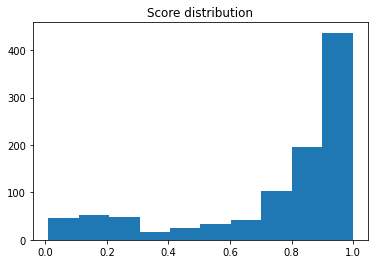

q_hat: 0.11895560116923032


In [5]:
# Compute quantile 
q_hat = compute_qhat(cal_class_probs, cal_true_labels, alpha=.05, plot_scores=True)
print('q_hat:', q_hat)

### Evaluate 

In [6]:
# Create prediction sets
def create_prediction_sets(class_probs, q_hat):
    assert(not hasattr(q_hat, '__iter__')) # q_hat should be a single number and not a list/array
    set_preds = []
    num_samples = len(class_probs)
    for i in range(num_samples):
        set_preds.append(np.where(class_probs[i,:] > q_hat)[0])
        
    return set_preds

# Helper function for computing accuracy (marginal coverage) of confidence sets
def compute_coverage(true_labels, set_preds):
    num_correct = 0
    for true_label, preds in zip(true_labels, set_preds):
        if true_label in preds:
            num_correct += 1
    set_pred_acc = num_correct / len(true_labels)
    
    return set_pred_acc

# Helper function for computing class-specific coverage of confidence sets
def compute_class_specific_coverage(true_labels, set_preds):
    num_classes = max(true_labels) + 1
    class_specific_cov = np.zeros((num_classes,))
    for k in range(num_classes):
        idx = np.where(true_labels == k)[0]
        selected_preds = [set_preds[i] for i in idx]
        num_correct = np.sum([1 if np.any(pred_set == k) else 0 for pred_set in selected_preds])
        class_specific_cov[k] = num_correct / len(selected_preds)
        
    return class_specific_cov


First, sanity check by evaluating coverage on calibration set (confidence sets should have accuracy very close to 1-alpha)

In [7]:
print('====== Using calibration set =======')

# Point prediction accuracy (e.g., accuracy when we only predict a single class)
point_preds = np.argmax(cal_class_probs, axis=1)
point_pred_acc = np.mean(point_preds == cal_true_labels)
print(f'Point prediction accuracy: {point_pred_acc*100:.2f}%')

# Set prediction accuracy
cal_set_preds = create_prediction_sets(cal_class_probs, q_hat)
# i) Marginal coverage
marginal_cov = compute_coverage(cal_true_labels, cal_set_preds)
print(f'Confidence set "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(cal_true_labels, cal_set_preds)
print(f'Confidence set "class specific coverage": {class_specific_cov}')


====== Using calibration set =======
Point prediction accuracy: 83.60%
Confidence set "marginal coverage": 95.10%
Confidence set "class specific coverage": [0.945      0.71962617 0.98979592 0.99315068 0.96491228]


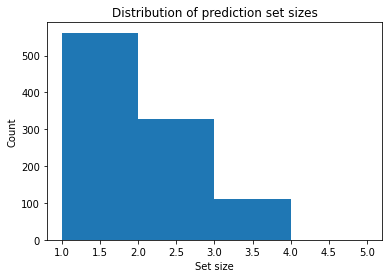

In [8]:
# Plot average set size for set predictions
set_sizes = [len(preds) for preds in cal_set_preds]
plt.hist(set_sizes, bins=range(1,6))
plt.xlabel('Set size')
plt.ylabel('Count')
plt.title('Distribution of prediction set sizes')
plt.show()

Now test on actual test set

In [9]:
print('====== Using test set =======')

# Point prediction accuracy (e.g., accuracy when we only predict a single class)
point_preds = np.argmax(test_class_probs, axis=1)
point_pred_acc = np.mean(point_preds == test_true_labels)
print(f'Point prediction accuracy: {point_pred_acc*100:.2f}%')


# Set prediction accuracy
set_preds = create_prediction_sets(test_class_probs, q_hat)
# i) Marginal coverage
marginal_cov = compute_coverage(test_true_labels, set_preds)
print(f'Confidence set "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(test_true_labels, set_preds)
print(f'Confidence set "class specific coverage": {class_specific_cov}')

====== Using test set =======
Point prediction accuracy: 82.74%
Confidence set "marginal coverage": 95.73%
Confidence set "class specific coverage": [0.96146435 0.75122429 0.99034982 0.98982361 0.93406593]


# How does coverage change with size of calibration set?
(Using standard conformal inference)

Variance of coverage should track variance of q_hat

In [10]:
# Use "infinite" (very large) test set for evaluating coverage
test_data_size = 10000
test_true_labels, test_class_probs = generate_synthetic_data(test_data_size)

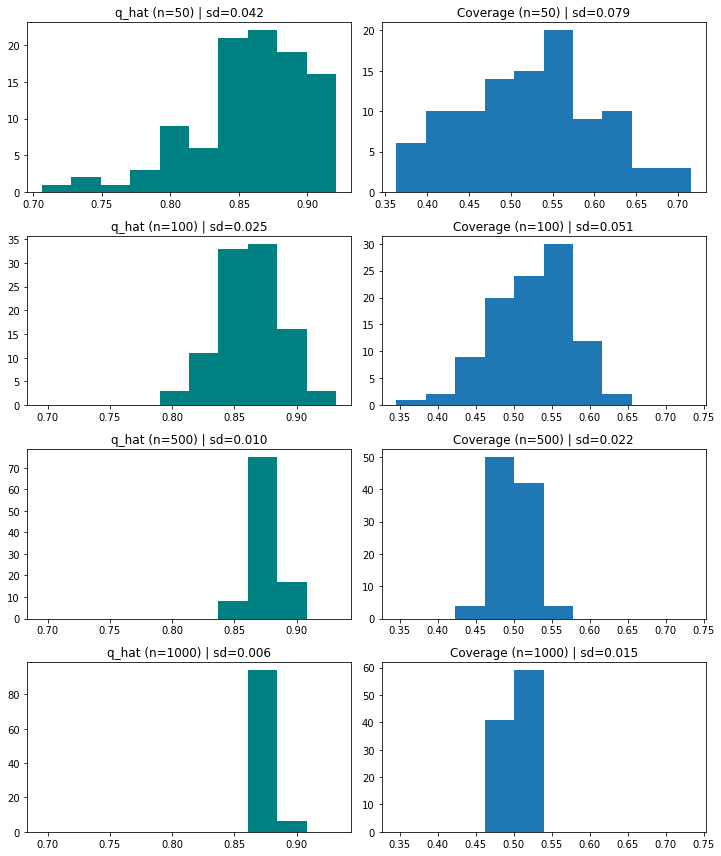

In [11]:
cal_set_sizes = [50, 100, 500, 1000]
num_trials = 100
alpha = 0.5
fig, ax = plt.subplots(len(cal_set_sizes),2, figsize=(10, len(cal_set_sizes)*3))

qhat_sds = np.zeros(len(cal_set_sizes),)
coverage_sds = np.zeros(len(cal_set_sizes),)
for j, num_samples in enumerate(cal_set_sizes):
    q_hat_list = np.zeros(num_trials,)
    coverage_list = np.zeros(num_trials,)
    for i in range(num_trials):
        cal_true_labels, cal_class_probs = generate_synthetic_data(num_samples)
        q_hat_list[i] = compute_qhat(cal_class_probs, cal_true_labels, alpha=alpha)
        set_preds = create_prediction_sets(test_class_probs, q_hat_list[i])
        coverage_list[i] = compute_coverage(test_true_labels, set_preds)
        
    # Compute standard deviations
    qhat_sds[j] = np.std(q_hat_list)
    coverage_sds[j] = np.std(coverage_list)
    
    # Plot
    # Force each column to use the same histogram bins
    if j == 0:
        xlims_qhat = None
        xlims_cov = None
    else:
        xlims_qhat = ax[0,0].get_xlim()
        xlims_cov = ax[0,1].get_xlim()
    ax[j,0].hist(q_hat_list, range=xlims_qhat, color='teal')
    ax[j,0].set_title(f'q_hat (n={num_samples}) | sd={qhat_sds[j]:.3f}')
    ax[j,1].hist(coverage_list, range=xlims_cov)
    ax[j,1].set_title(f'Coverage (n={num_samples}) | sd={coverage_sds[j]:.3f}')


# ax[0,0].get_shared_x_axes().join(*ax[:,0])
# ax[0,1].get_shared_x_axes().join(*ax[:,1])

plt.tight_layout()
plt.show()

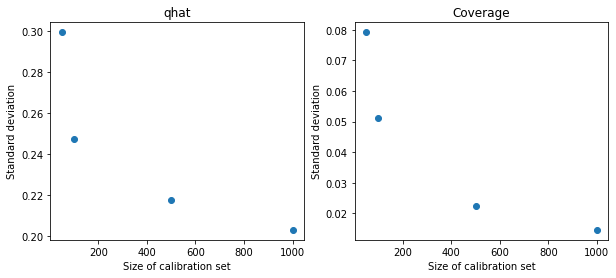

In [12]:
# Plot standard deviations vs. size of calibration set
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(cal_set_sizes, qhat_sds * np.sqrt(cal_set_sizes))
ax[0].set_xlabel('Size of calibration set')
ax[0].set_ylabel('Standard deviation')
ax[0].set_title('qhat')

ax[1].scatter(cal_set_sizes, coverage_sds)
ax[1].set_xlabel('Size of calibration set')
ax[1].set_ylabel('Standard deviation')
ax[1].set_title('Coverage')
plt.show()

# Naive class-balanced conformal inference

Procedure:
1. Partition calibration dataset based on true label
1. Estimate class-specific quantile using corresponding partition of the dataset
1. To create a confidence set, include a class in the set if its score exceeds the corresponding class-specific quantile

In [13]:
np.random.seed(0)

# Generate calibration data
calibration_data_size = 10000
cal_true_labels, cal_class_probs = generate_synthetic_data(calibration_data_size)

# Generate testing data
test_data_size = 10000
test_true_labels, test_class_probs = generate_synthetic_data(test_data_size)

In [21]:
def compute_class_specific_quantiles(cal_true_labels, cal_class_probs, alpha=.05):
    num_samples = len(cal_true_labels)
    q_hats = np.zeros((5,)) # q_hats[i] = quantile for class i
    for k in range(cal_class_probs.shape[1]):
        # Only select data for which k is true class
        idx = (cal_true_labels == k)
        scores = cal_class_probs[idx, k]
        scores = np.sort(scores)
        q_hats[k] = -np.quantile(-scores, np.ceil((num_samples+1)*(1-alpha))/num_samples)
        
    return q_hats
    
q_hats = compute_class_specific_quantiles(cal_true_labels, cal_class_probs, alpha=.05)
print('q_hats:', q_hats)

q_hats: [0.17688255 0.05033141 0.45056126 0.42192517 0.0770898 ]


In [15]:
# Create class_balanced prediction sets
def create_cb_prediction_sets(class_probs, q_hats):
    set_preds = []
    num_samples = len(class_probs)
    for i in range(num_samples):
#         print(class_probs, q_hats)
#         print(np.where(class_probs[i,:] > q_hats)[0])
        set_preds.append(np.where(class_probs[i,:] > q_hats)[0])
        
    return set_preds

In [16]:
print('====== Using calibration set =======')

# Point prediction accuracy (e.g., accuracy when we only predict a single class)
point_preds = np.argmax(cal_class_probs, axis=1)
point_pred_acc = np.mean(point_preds == cal_true_labels)
print(f'Point prediction accuracy: {point_pred_acc*100:.2f}%')

# Set prediction accuracy
q_hat = compute_qhat(cal_class_probs, cal_true_labels, alpha=.05)
set_preds = create_prediction_sets(cal_class_probs, q_hat)
# i) Marginal coverage
marginal_cov = compute_coverage(cal_true_labels, set_preds)
print(f'Confidence set "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(cal_true_labels, set_preds)
print(f'Confidence set "class specific coverage": {class_specific_cov}')

# Class-balanced set prediction accuracy
set_preds = create_cb_prediction_sets(cal_class_probs, q_hats)
# i) Marginal coverage
marginal_cov = compute_coverage(cal_true_labels, set_preds)
print(f'Class-balanced confidence set "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(cal_true_labels, set_preds)
print(f'Class-balanced confidence set "class specific coverage": {class_specific_cov}')

====== Using calibration set =======
Point prediction accuracy: 83.72%
Confidence set "marginal coverage": 95.01%
Confidence set "class specific coverage": [0.95679612 0.69547739 0.98914136 0.99052774 0.92105263]
Class-balanced confidence set "marginal coverage": 95.08%
Class-balanced confidence set "class specific coverage": [0.95097087 0.95075377 0.95093505 0.95060893 0.94939271]


# Empirical Bayes class-balanced conformal inference

In [17]:
# TODO 